In [1]:
import numpy as np
import pandas as pd
import statistics as stat
import scipy
import math as m

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Korisni linkovi 

# Numpy: https://numpy.org/
# Pandas: https://pandas.pydata.org/


In [3]:
years = ('FY21A', 'FY22E', 'FY23F', 'FY24F', 'FY25F', 'FY26F', 'FY27F')
sales = pd.Series(index = years)
#print(sales)

sales['FY21A'] =  21101 
#print(sales)

/tmp/ipykernel_32/1746477868.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sales = pd.Series(index = years)


In [4]:
sales_growth_rate = [0.7 for i in range(6)] # Red Fleg 1
# print(sales_growth_dist)

for year in range(1, 7):
    sales[year] = (sales[year - 1] * (1 + sales_growth_rate[year - 1])).round(2)
    
#print(sales)

In [5]:
ebitda_margin = 0.7
depr_margin = 0.3

ebitda = sales * ebitda_margin
depreciation = sales * depr_margin
ebit = ebitda - depreciation

nwc_estimate = pd.Series((1802, 1576, 2580, 5131, 47385, 38844, 13746), index = years)
change_in_nwc = -(nwc_estimate.shift(1) - nwc_estimate)[1:] 

# print(change_in_nwc)

capex_percent = depr_margin
capex_estimate = - (sales * capex_percent)

# capex_estimate = pd.Series((9236, 48605, 105677, 656107, 565052, 36535), index = years[1:])

tax_rate = 0.15
tax_payment = ebit * tax_rate
tax_payment = tax_payment.apply(lambda x: max(x, 0))

free_cash_flow = (ebit - tax_payment + depreciation  + capex_estimate + change_in_nwc).round(2)[1:]

print(free_cash_flow)

FY22E     11970.38
FY23F     21737.84
FY24F     37798.53
FY25F    102174.80
FY26F     93324.37
FY27F    148073.12
dtype: float64


In [6]:
capex = pd.Series([10204, 53229, 102684, 595538, 688255, 29981], index = years[1:])
# print(capex)

capex = - capex

# print(capex)

In [7]:
cost_of_capital = 0.137 # Red Fleg 2
terminal_growth = 0.02 # Red Fleg 3

terminal_value = ((free_cash_flow[-1] * (1 + terminal_growth)) / (cost_of_capital - terminal_growth))

discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,7)]
dcf_value = (sum(free_cash_flow * discount_factors) + terminal_value * discount_factors[-1])

In [8]:
output = pd.DataFrame([sales, ebit, free_cash_flow], index = ['Sales', 'EBIT', 'Free Cash Flow']).round(1)
#output.drop(columns = 'FY21A', inplace = True)

print(output)

                  FY21A    FY22E    FY23F    FY24F     FY25F     FY26F  \
Sales           21101.0  31651.5  47477.2  71215.9  106823.8  160235.7   
EBIT             8440.4  12660.6  18990.9  28486.4   42729.5   64094.3   
Free Cash Flow      NaN  10535.5  17146.3  26764.4   78574.1   45939.2   

                   FY27F  
Sales           240353.6  
EBIT             96141.4  
Free Cash Flow   56622.2  


In [86]:
#np.random.seed(2023)

def dcf():
    
    sales_growth_random = np.random.normal(loc = sales_growth_rate[0], scale = 0.4, size = 1)
    ebitda_margin_random = np.random.normal(loc = ebitda_margin, scale = 0.1, size = 1)
    capex_percent = np.random.choice([0.5 * depr_margin, depr_margin, 1.5 * depr_margin, 2 * depr_margin, 2.5 * depr_margin], size = 1, p = [0.2, 0.3, 0.15, 0.2, 0.15])
    
    terminal_growth_random = np.random.uniform(terminal_growth - 0.02, terminal_growth + 0.02, size = 1)
    cost_of_capital_random = np.random.uniform(cost_of_capital - 0.1, cost_of_capital + 0.1, size = 1)
    
    for year in range(1, 7):
        sales[year] = sales[year - 1] * (1 + sales_growth_random)
        
    ebitda = sales * ebitda_margin_random
    # print(ebitda)
    
    depreciation = (sales * depr_margin)
    ebit = ebitda - depreciation
    # print(ebit)
    
    tax_payment = ebit * tax_rate
    tax_payment = tax_payment.apply(lambda x: max(x, 0))
    
    gross_fcff = ebit - tax_payment
    # print(gross_fcff)
    
    #capex_percent = depr_margin
    capex_estimate = - (sales * capex_percent)
    
    
    nwc_estimate = pd.Series((1802, 1576, 2580, 5131, 47385, 38844, 13746), index = years)
    change_in_nwc = (nwc_estimate.shift(1) - nwc_estimate)[1:] 
    
    free_cash_flow = gross_fcff + depreciation + capex_estimate - change_in_nwc

    terminal_value = (free_cash_flow[-1] * terminal_growth_random) / (cost_of_capital - terminal_growth_random)
    free_cash_flow[-1] += terminal_value
    discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,7)]
    enterprise_value = sum(free_cash_flow[1:] * discount_factors)
    
    return enterprise_value

dcf()

153725.04144851313

In [87]:
output_distribution = list()

for i in range(10000):
    output_distribution.append(dcf())
    
output_distribution = np.array(output_distribution)

output_distribution.mean(), output_distribution.std()

(256748.59418022493, 481086.5820243885)

In [88]:
interest_bearing_debt = 85577

equity = output_distribution.mean() - interest_bearing_debt

no_of_shares = 26511

mean = (equity/no_of_shares).round(2)

print(mean)

6.46


In [92]:
prices_list = (output_distribution - 85577)/26511

prices_list = np.where(prices_list < 0, 0, prices_list)

print(prices_list)

import statistics

print(np.percentile(sorted(prices_list), 75))

[ 1.74500477 27.47567267  0.         ...  0.         55.46044784
 21.26866184]
9.361819935544819


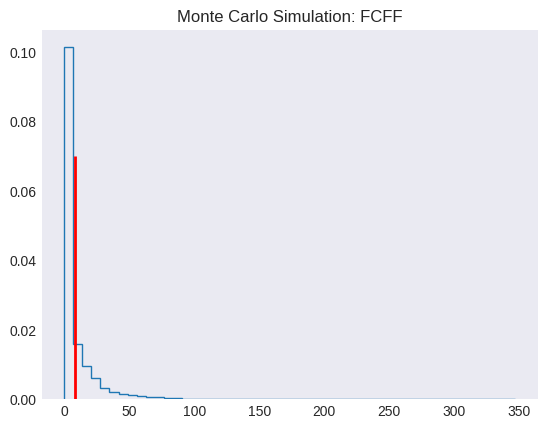

In [93]:
plt.style.use('_classic_test_patch')

plt.hist(prices_list, density = True, bins = 50, histtype = 'step')
plt.ticklabel_format(style='plain')
plt.vlines(x = prices_list.mean(), ymin = 0, ymax = 0.07, color = 'red', lw = 2)
plt.title('Monte Carlo Simulation: FCFF')

plt.show()

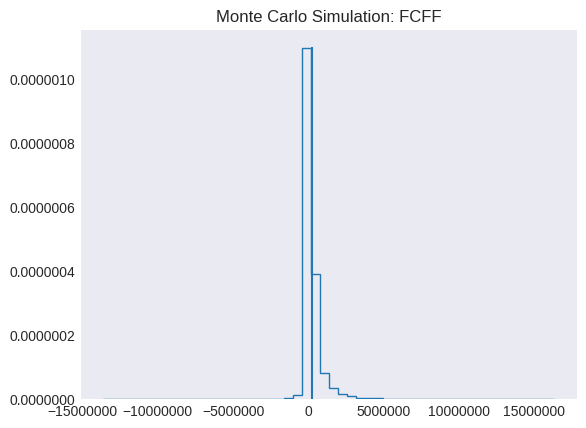

In [61]:
plt.style.use('_classic_test_patch')

plt.hist(output_distribution, density = True, bins = 50, histtype = 'step')
plt.ticklabel_format(style='plain')
plt.vlines(x = output_distribution.mean(), ymin = 0, ymax = 0.0000011)
plt.title('Monte Carlo Simulation: FCFF')

plt.show()

In [26]:
# np.count_nonzero?

In [27]:
output_distribution = pd.DataFrame(output_distribution)
#print(output_distribution)

output_file = pd.DataFrame.to_csv(output_distribution)

In [28]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [29]:
#help(plt.hist)

In [94]:
plt.style.use('seaborn-v0_8-dark')
from IPython.display import display
import ipywidgets as widgets

def run_mc(n, plot_density):
    
    iterations = n
    
    output_distribution = list()

    for i in range(iterations):
        output_distribution.append(dcf())
    
    output_distribution = np.array(output_distribution)

    output_distribution.mean(), output_distribution.std()
        
    if plot_density:
        x = np.linspace(output_distribution.min() - 15000, output_distribution.max() + 15000, 100)
        density = (1 / (np.sqrt(2 * np.pi) * output_distribution.std())) * np.exp(-0.5 * ((x - output_distribution.mean()) / output_distribution.std()) ** 2)
        plt.plot(x, density, color = '#4f5051', linewidth = 2)
    
    plt.hist(output_distribution, bins = 50, color = '#1f318d', density = True)
    plt.ticklabel_format(style = 'plain')
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.title('Korišćenje interaktivnih grafikona: Ipywidgets biblioteka', fontsize = 9)
    plt.show()
    
checkbox = widgets.Checkbox(value = False, description = 'Funkcija gustine: Da/Ne?')

interactive_plot = widgets.interactive(run_mc, n = widgets.IntSlider(min=10, max=10000, step=100, value=1000), plot_density = checkbox)
display(interactive_plot)

# widgets.IntSlider(min=10, max=10000, step=100, value=1000)

# Malo kompleksnije: 

from ipywidgets import FloatSlider

#interactive_plot = widgets.interact_manual(run_mc,n = widgets.IntSlider(min=10, max=1e3, step = 1), plot_density = checkbox)
#display(interactive_plot)

# Link: https://ipywidgets.readthedocs.io/en/7.6.2/examples/Using%20Interact.html

interactive(children=(IntSlider(value=1000, description='n', max=10000, min=10, step=100), Checkbox(value=Fals…

In [1]:
!pip install yfinance
!pip install yahoofinancials

import yfinance as yf
from yahoofinancials import YahooFinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28644 sha256=84eb00d43c76abb024f71fcd5bf48b2e32a94b395551e66f1f824182a05d7159
  Stored in directory: /root/.cache/pip/wheels/32/a3/b6/b5b33187f2d42f095fecc236b957b46173fa09e78a106e309f
Successfully built yahoofinancials


In [41]:
stock = yf.Ticker('PG')
# print(dir(stock))
print(stock.info)

{'address1': 'One Procter & Gamble Plaza', 'city': 'Cincinnati', 'state': 'OH', 'zip': '45202', 'country': 'United States', 'phone': '513 983 1100', 'website': 'https://www.pginvestor.com', 'industry': 'Household & Personal Products', 'industryDisp': 'Household & Personal Products', 'sector': 'Consumer Defensive', 'longBusinessSummary': 'The Procter & Gamble Company provides branded consumer packaged goods worldwide. It operates through five segments: Beauty; Grooming; Health Care; Fabric & Home Care; and Baby, Feminine & Family Care. The Beauty segment offers conditioners, shampoos, styling aids, and treatments under the Head & Shoulders, Herbal Essences, Pantene, and Rejoice brands; and antiperspirants and deodorants, personal cleansing, and skin care products under the Olay, Old Spice, Safeguard, Secret, and SK-II brands. The Grooming segment provides shave care products and appliances under the Braun, Gillette, and Venus brand names. The Health Care segment offers toothbrushes, too

In [4]:
ticker_symbols = ['MRVL', 'SYY', 'GPS', 'RYAAY', 'BXP']

for i in ticker_symbols:
    print('Kompanija', yf.Ticker(i).info['longName'], '; Preporuka', yf.Ticker(i).info['recommendationKey'])

Kompanija Marvell Technology, Inc. ; Preporuka buy
Kompanija Sysco Corporation ; Preporuka buy
Kompanija The Gap, Inc. ; Preporuka hold
Kompanija Ryanair Holdings plc ; Preporuka strong_buy
Kompanija Boston Properties, Inc. ; Preporuka hold
